##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


2023-09-28 07:21:27.786660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-28 07:21:27.786717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-28 07:21:27.786758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)

2.14.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   40960/84125825 [..............................] - ETA: 3:17

  106496/84125825 [..............................] - ETA: 2:31

  221184/84125825 [..............................] - ETA: 1:49

  401408/84125825 [..............................] - ETA: 1:19

  565248/84125825 [..............................] - ETA: 1:03

  876544/84125825 [..............................] - ETA: 45s 

 1171456/84125825 [..............................] - ETA: 40s

 1531904/84125825 [..............................] - ETA: 33s

 2039808/84125825 [..............................] - ETA: 27s

 2662400/84125825 [..............................] - ETA: 22s

 3350528/84125825 [>.............................] - ETA: 19s

 4186112/84125825 [>.............................] - ETA: 16s

 5234688/84125825 [>.............................] - ETA: 13s

 6529024/84125825 [=>............................] - ETA: 11s

 8101888/84125825 [=>............................] - ETA: 9s 

 9953280/84125825 [==>...........................] - ETA: 7s

12148736/84125825 [===>..........................] - ETA: 6s

14712832/84125825 [====>.........................] - ETA: 5s

17752064/84125825 [=====>........................] - ETA: 4s

20717568/84125825 [======>.......................] - ETA: 3s

23633920/84125825 [=======>......................] - ETA: 3s

26877952/84125825 [========>.....................] - ETA: 2s

30105600/84125825 [=========>....................] - ETA: 2s

33071104/84125825 [==========>...................] - ETA: 2s

36167680/84125825 [===========>..................] - ETA: 2s

39460864/84125825 [=============>................] - ETA: 1s

42721280/84125825 [==============>...............] - ETA: 1s

45735936/84125825 [===============>..............] - ETA: 1s

48619520/84125825 [================>.............] - ETA: 1s

51830784/84125825 [=================>............] - ETA: 1s

55074816/84125825 [==================>...........] - ETA: 0s

58040320/84125825 [===================>..........] - ETA: 0s

61267968/84125825 [====================>.........] - ETA: 0s

64282624/84125825 [=====================>........] - ETA: 0s

67510272/84125825 [=======================>......] - ETA: 0s

70737920/84125825 [========================>.....] - ETA: 0s

73850880/84125825 [=========================>....] - ETA: 0s

76849152/84125825 [==========================>...] - ETA: 0s

79749120/84125825 [===========================>..] - ETA: 0s

83009536/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 2s 0us/step


In [6]:
os.listdir(dataset_dir)

['test', 'imdbEr.txt', 'train', 'README', 'imdb.vocab']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'urls_pos.txt',
 'urls_neg.txt',
 'unsup',
 'pos',
 'urls_unsup.txt',
 'neg',
 'labeledBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 20000 files for training.


2023-09-28 07:21:54.079481: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (  (None, 16)                0         


 GlobalAveragePooling1D)                                         


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160033 (625.13 KB)


Trainable params: 160033 (625.13 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 5:58 - loss: 0.6922 - binary_accuracy: 0.5625

 11/625 [..............................] - ETA: 3s - loss: 0.6931 - binary_accuracy: 0.5142  

 25/625 [>.............................] - ETA: 2s - loss: 0.6931 - binary_accuracy: 0.5138

 39/625 [>.............................] - ETA: 2s - loss: 0.6928 - binary_accuracy: 0.5184

 54/625 [=>............................] - ETA: 2s - loss: 0.6920 - binary_accuracy: 0.5544

 68/625 [==>...........................] - ETA: 2s - loss: 0.6917 - binary_accuracy: 0.5515

 83/625 [==>...........................] - ETA: 2s - loss: 0.6914 - binary_accuracy: 0.5452

 98/625 [===>..........................] - ETA: 1s - loss: 0.6913 - binary_accuracy: 0.5386

113/625 [====>.........................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5393

128/625 [=====>........................] - ETA: 1s - loss: 0.6908 - binary_accuracy: 0.5520

142/625 [=====>........................] - ETA: 1s - loss: 0.6904 - binary_accuracy: 0.5671

157/625 [======>.......................] - ETA: 1s - loss: 0.6900 - binary_accuracy: 0.5802

172/625 [=======>......................] - ETA: 1s - loss: 0.6896 - binary_accuracy: 0.5923

187/625 [=======>......................] - ETA: 1s - loss: 0.6892 - binary_accuracy: 0.5931

203/625 [========>.....................] - ETA: 1s - loss: 0.6888 - binary_accuracy: 0.5904

219/625 [=========>....................] - ETA: 1s - loss: 0.6882 - binary_accuracy: 0.5970

234/625 [==========>...................] - ETA: 1s - loss: 0.6877 - binary_accuracy: 0.6048

249/625 [==========>...................] - ETA: 1s - loss: 0.6870 - binary_accuracy: 0.6127

265/625 [===========>..................] - ETA: 1s - loss: 0.6863 - binary_accuracy: 0.6190

280/625 [============>.................] - ETA: 1s - loss: 0.6856 - binary_accuracy: 0.6234

296/625 [=============>................] - ETA: 1s - loss: 0.6851 - binary_accuracy: 0.6274

311/625 [=============>................] - ETA: 1s - loss: 0.6844 - binary_accuracy: 0.6319

326/625 [==============>...............] - ETA: 1s - loss: 0.6839 - binary_accuracy: 0.6346

341/625 [===============>..............] - ETA: 0s - loss: 0.6831 - binary_accuracy: 0.6388

356/625 [================>.............] - ETA: 0s - loss: 0.6825 - binary_accuracy: 0.6412

371/625 [================>.............] - ETA: 0s - loss: 0.6817 - binary_accuracy: 0.6459

386/625 [=================>............] - ETA: 0s - loss: 0.6808 - binary_accuracy: 0.6516

401/625 [==================>...........] - ETA: 0s - loss: 0.6798 - binary_accuracy: 0.6555

416/625 [==================>...........] - ETA: 0s - loss: 0.6789 - binary_accuracy: 0.6591

431/625 [===================>..........] - ETA: 0s - loss: 0.6779 - binary_accuracy: 0.6624

447/625 [====================>.........] - ETA: 0s - loss: 0.6769 - binary_accuracy: 0.6662

462/625 [=====================>........] - ETA: 0s - loss: 0.6760 - binary_accuracy: 0.6691

478/625 [=====================>........] - ETA: 0s - loss: 0.6750 - binary_accuracy: 0.6710

493/625 [======================>.......] - ETA: 0s - loss: 0.6738 - binary_accuracy: 0.6746

509/625 [=======================>......] - ETA: 0s - loss: 0.6727 - binary_accuracy: 0.6773

524/625 [========================>.....] - ETA: 0s - loss: 0.6717 - binary_accuracy: 0.6793

539/625 [========================>.....] - ETA: 0s - loss: 0.6708 - binary_accuracy: 0.6816

555/625 [=========================>....] - ETA: 0s - loss: 0.6696 - binary_accuracy: 0.6843

570/625 [==========================>...] - ETA: 0s - loss: 0.6684 - binary_accuracy: 0.6862

585/625 [===========================>..] - ETA: 0s - loss: 0.6674 - binary_accuracy: 0.6879

600/625 [===========================>..] - ETA: 0s - loss: 0.6661 - binary_accuracy: 0.6906

615/625 [============================>.] - ETA: 0s - loss: 0.6648 - binary_accuracy: 0.6927

625/625 [==============================] - 3s 4ms/step - loss: 0.6641 - binary_accuracy: 0.6936 - val_loss: 0.6154 - val_binary_accuracy: 0.7716


Epoch 2/10


  1/625 [..............................] - ETA: 3s - loss: 0.5783 - binary_accuracy: 0.8125

 16/625 [..............................] - ETA: 2s - loss: 0.6072 - binary_accuracy: 0.7812

 31/625 [>.............................] - ETA: 2s - loss: 0.6073 - binary_accuracy: 0.7752

 47/625 [=>............................] - ETA: 1s - loss: 0.6074 - binary_accuracy: 0.7726

 62/625 [=>............................] - ETA: 1s - loss: 0.6048 - binary_accuracy: 0.7757

 77/625 [==>...........................] - ETA: 1s - loss: 0.6046 - binary_accuracy: 0.7715

 92/625 [===>..........................] - ETA: 1s - loss: 0.6022 - binary_accuracy: 0.7731

107/625 [====>.........................] - ETA: 1s - loss: 0.6001 - binary_accuracy: 0.7745

123/625 [====>.........................] - ETA: 1s - loss: 0.5991 - binary_accuracy: 0.7726

138/625 [=====>........................] - ETA: 1s - loss: 0.5982 - binary_accuracy: 0.7736

152/625 [======>.......................] - ETA: 1s - loss: 0.5973 - binary_accuracy: 0.7734

168/625 [=======>......................] - ETA: 1s - loss: 0.5952 - binary_accuracy: 0.7757

184/625 [=======>......................] - ETA: 1s - loss: 0.5936 - binary_accuracy: 0.7763

200/625 [========>.....................] - ETA: 1s - loss: 0.5930 - binary_accuracy: 0.7750

215/625 [=========>....................] - ETA: 1s - loss: 0.5911 - binary_accuracy: 0.7770

230/625 [==========>...................] - ETA: 1s - loss: 0.5888 - binary_accuracy: 0.7792

245/625 [==========>...................] - ETA: 1s - loss: 0.5869 - binary_accuracy: 0.7801

260/625 [===========>..................] - ETA: 1s - loss: 0.5852 - binary_accuracy: 0.7803

275/625 [============>.................] - ETA: 1s - loss: 0.5828 - binary_accuracy: 0.7830

291/625 [============>.................] - ETA: 1s - loss: 0.5819 - binary_accuracy: 0.7821

306/625 [=============>................] - ETA: 1s - loss: 0.5807 - binary_accuracy: 0.7825

321/625 [==============>...............] - ETA: 1s - loss: 0.5797 - binary_accuracy: 0.7816

336/625 [===============>..............] - ETA: 0s - loss: 0.5783 - binary_accuracy: 0.7826

351/625 [===============>..............] - ETA: 0s - loss: 0.5770 - binary_accuracy: 0.7836

367/625 [================>.............] - ETA: 0s - loss: 0.5752 - binary_accuracy: 0.7853

382/625 [=================>............] - ETA: 0s - loss: 0.5734 - binary_accuracy: 0.7869

397/625 [==================>...........] - ETA: 0s - loss: 0.5715 - binary_accuracy: 0.7886

412/625 [==================>...........] - ETA: 0s - loss: 0.5699 - binary_accuracy: 0.7896

427/625 [===================>..........] - ETA: 0s - loss: 0.5678 - binary_accuracy: 0.7912

442/625 [====================>.........] - ETA: 0s - loss: 0.5662 - binary_accuracy: 0.7918

457/625 [====================>.........] - ETA: 0s - loss: 0.5647 - binary_accuracy: 0.7927

473/625 [=====================>........] - ETA: 0s - loss: 0.5635 - binary_accuracy: 0.7930

489/625 [======================>.......] - ETA: 0s - loss: 0.5617 - binary_accuracy: 0.7942

505/625 [=======================>......] - ETA: 0s - loss: 0.5601 - binary_accuracy: 0.7952

521/625 [========================>.....] - ETA: 0s - loss: 0.5583 - binary_accuracy: 0.7965

536/625 [========================>.....] - ETA: 0s - loss: 0.5574 - binary_accuracy: 0.7965

552/625 [=========================>....] - ETA: 0s - loss: 0.5557 - binary_accuracy: 0.7976

568/625 [==========================>...] - ETA: 0s - loss: 0.5543 - binary_accuracy: 0.7981

584/625 [===========================>..] - ETA: 0s - loss: 0.5530 - binary_accuracy: 0.7984

599/625 [===========================>..] - ETA: 0s - loss: 0.5515 - binary_accuracy: 0.7996

614/625 [============================>.] - ETA: 0s - loss: 0.5502 - binary_accuracy: 0.8003

625/625 [==============================] - 2s 4ms/step - loss: 0.5492 - binary_accuracy: 0.8007 - val_loss: 0.4988 - val_binary_accuracy: 0.8238


Epoch 3/10


  1/625 [..............................] - ETA: 2s - loss: 0.4490 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 2s - loss: 0.4845 - binary_accuracy: 0.8438

 32/625 [>.............................] - ETA: 1s - loss: 0.4850 - binary_accuracy: 0.8311

 48/625 [=>............................] - ETA: 1s - loss: 0.4848 - binary_accuracy: 0.8301

 63/625 [==>...........................] - ETA: 1s - loss: 0.4833 - binary_accuracy: 0.8304

 78/625 [==>...........................] - ETA: 1s - loss: 0.4840 - binary_accuracy: 0.8249

 94/625 [===>..........................] - ETA: 1s - loss: 0.4822 - binary_accuracy: 0.8271

109/625 [====>.........................] - ETA: 1s - loss: 0.4793 - binary_accuracy: 0.8283

124/625 [====>.........................] - ETA: 1s - loss: 0.4785 - binary_accuracy: 0.8279

139/625 [=====>........................] - ETA: 1s - loss: 0.4774 - binary_accuracy: 0.8278

154/625 [======>.......................] - ETA: 1s - loss: 0.4785 - binary_accuracy: 0.8263

170/625 [=======>......................] - ETA: 1s - loss: 0.4766 - binary_accuracy: 0.8290

186/625 [=======>......................] - ETA: 1s - loss: 0.4761 - binary_accuracy: 0.8283

202/625 [========>.....................] - ETA: 1s - loss: 0.4756 - binary_accuracy: 0.8287

218/625 [=========>....................] - ETA: 1s - loss: 0.4738 - binary_accuracy: 0.8307

233/625 [==========>...................] - ETA: 1s - loss: 0.4726 - binary_accuracy: 0.8321

249/625 [==========>...................] - ETA: 1s - loss: 0.4704 - binary_accuracy: 0.8326

265/625 [===========>..................] - ETA: 1s - loss: 0.4685 - binary_accuracy: 0.8350

280/625 [============>.................] - ETA: 1s - loss: 0.4666 - binary_accuracy: 0.8360

295/625 [=============>................] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8340

311/625 [=============>................] - ETA: 1s - loss: 0.4663 - binary_accuracy: 0.8350

327/625 [==============>...............] - ETA: 0s - loss: 0.4659 - binary_accuracy: 0.8351

342/625 [===============>..............] - ETA: 0s - loss: 0.4649 - binary_accuracy: 0.8355

357/625 [================>.............] - ETA: 0s - loss: 0.4639 - binary_accuracy: 0.8362

373/625 [================>.............] - ETA: 0s - loss: 0.4624 - binary_accuracy: 0.8379

388/625 [=================>............] - ETA: 0s - loss: 0.4609 - binary_accuracy: 0.8388

403/625 [==================>...........] - ETA: 0s - loss: 0.4591 - binary_accuracy: 0.8402

419/625 [===================>..........] - ETA: 0s - loss: 0.4576 - binary_accuracy: 0.8410

435/625 [===================>..........] - ETA: 0s - loss: 0.4564 - binary_accuracy: 0.8415

451/625 [====================>.........] - ETA: 0s - loss: 0.4551 - binary_accuracy: 0.8422

467/625 [=====================>........] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.8433

483/625 [======================>.......] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.8432

499/625 [======================>.......] - ETA: 0s - loss: 0.4517 - binary_accuracy: 0.8443

514/625 [=======================>......] - ETA: 0s - loss: 0.4503 - binary_accuracy: 0.8454

529/625 [========================>.....] - ETA: 0s - loss: 0.4495 - binary_accuracy: 0.8453

544/625 [=========================>....] - ETA: 0s - loss: 0.4488 - binary_accuracy: 0.8454

560/625 [=========================>....] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.8458

575/625 [==========================>...] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.8463

590/625 [===========================>..] - ETA: 0s - loss: 0.4469 - binary_accuracy: 0.8461

605/625 [============================>.] - ETA: 0s - loss: 0.4460 - binary_accuracy: 0.8468

620/625 [============================>.] - ETA: 0s - loss: 0.4455 - binary_accuracy: 0.8463

625/625 [==============================] - 2s 4ms/step - loss: 0.4450 - binary_accuracy: 0.8466 - val_loss: 0.4204 - val_binary_accuracy: 0.8470


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3729 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.3954 - binary_accuracy: 0.8594

 31/625 [>.............................] - ETA: 2s - loss: 0.3956 - binary_accuracy: 0.8669

 46/625 [=>............................] - ETA: 1s - loss: 0.4001 - binary_accuracy: 0.8594

 62/625 [=>............................] - ETA: 1s - loss: 0.3990 - binary_accuracy: 0.8594

 78/625 [==>...........................] - ETA: 1s - loss: 0.4029 - binary_accuracy: 0.8558

 93/625 [===>..........................] - ETA: 1s - loss: 0.4013 - binary_accuracy: 0.8575

109/625 [====>.........................] - ETA: 1s - loss: 0.3999 - binary_accuracy: 0.8578

125/625 [=====>........................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8580

141/625 [=====>........................] - ETA: 1s - loss: 0.3977 - binary_accuracy: 0.8575

157/625 [======>.......................] - ETA: 1s - loss: 0.4009 - binary_accuracy: 0.8545

173/625 [=======>......................] - ETA: 1s - loss: 0.3990 - binary_accuracy: 0.8564

189/625 [========>.....................] - ETA: 1s - loss: 0.3975 - binary_accuracy: 0.8562

205/625 [========>.....................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8561

219/625 [=========>....................] - ETA: 1s - loss: 0.3971 - binary_accuracy: 0.8572

235/625 [==========>...................] - ETA: 1s - loss: 0.3977 - binary_accuracy: 0.8566

250/625 [===========>..................] - ETA: 1s - loss: 0.3950 - binary_accuracy: 0.8576

266/625 [===========>..................] - ETA: 1s - loss: 0.3935 - binary_accuracy: 0.8601

281/625 [============>.................] - ETA: 1s - loss: 0.3926 - binary_accuracy: 0.8609

296/625 [=============>................] - ETA: 1s - loss: 0.3943 - binary_accuracy: 0.8594

312/625 [=============>................] - ETA: 1s - loss: 0.3938 - binary_accuracy: 0.8591

327/625 [==============>...............] - ETA: 0s - loss: 0.3933 - binary_accuracy: 0.8593

343/625 [===============>..............] - ETA: 0s - loss: 0.3922 - binary_accuracy: 0.8594

359/625 [================>.............] - ETA: 0s - loss: 0.3913 - binary_accuracy: 0.8599

374/625 [================>.............] - ETA: 0s - loss: 0.3904 - binary_accuracy: 0.8608

389/625 [=================>............] - ETA: 0s - loss: 0.3891 - binary_accuracy: 0.8610

405/625 [==================>...........] - ETA: 0s - loss: 0.3875 - binary_accuracy: 0.8618

421/625 [===================>..........] - ETA: 0s - loss: 0.3861 - binary_accuracy: 0.8627

436/625 [===================>..........] - ETA: 0s - loss: 0.3853 - binary_accuracy: 0.8629

452/625 [====================>.........] - ETA: 0s - loss: 0.3846 - binary_accuracy: 0.8632

468/625 [=====================>........] - ETA: 0s - loss: 0.3833 - binary_accuracy: 0.8643

484/625 [======================>.......] - ETA: 0s - loss: 0.3832 - binary_accuracy: 0.8641

499/625 [======================>.......] - ETA: 0s - loss: 0.3820 - binary_accuracy: 0.8650

515/625 [=======================>......] - ETA: 0s - loss: 0.3809 - binary_accuracy: 0.8657

531/625 [========================>.....] - ETA: 0s - loss: 0.3805 - binary_accuracy: 0.8654

547/625 [=========================>....] - ETA: 0s - loss: 0.3802 - binary_accuracy: 0.8657

563/625 [==========================>...] - ETA: 0s - loss: 0.3796 - binary_accuracy: 0.8657

579/625 [==========================>...] - ETA: 0s - loss: 0.3796 - binary_accuracy: 0.8652

595/625 [===========================>..] - ETA: 0s - loss: 0.3792 - binary_accuracy: 0.8654

611/625 [============================>.] - ETA: 0s - loss: 0.3791 - binary_accuracy: 0.8655

625/625 [==============================] - 2s 4ms/step - loss: 0.3786 - binary_accuracy: 0.8654 - val_loss: 0.3738 - val_binary_accuracy: 0.8602


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3310 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.3447 - binary_accuracy: 0.8842

 33/625 [>.............................] - ETA: 1s - loss: 0.3458 - binary_accuracy: 0.8835

 49/625 [=>............................] - ETA: 1s - loss: 0.3460 - binary_accuracy: 0.8782

 64/625 [==>...........................] - ETA: 1s - loss: 0.3454 - binary_accuracy: 0.8770

 80/625 [==>...........................] - ETA: 1s - loss: 0.3495 - binary_accuracy: 0.8723

 96/625 [===>..........................] - ETA: 1s - loss: 0.3507 - binary_accuracy: 0.8704

111/625 [====>.........................] - ETA: 1s - loss: 0.3487 - binary_accuracy: 0.8711

127/625 [=====>........................] - ETA: 1s - loss: 0.3487 - binary_accuracy: 0.8720

143/625 [=====>........................] - ETA: 1s - loss: 0.3482 - binary_accuracy: 0.8711

159/625 [======>.......................] - ETA: 1s - loss: 0.3511 - binary_accuracy: 0.8699

175/625 [=======>......................] - ETA: 1s - loss: 0.3482 - binary_accuracy: 0.8730

191/625 [========>.....................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8724

207/625 [========>.....................] - ETA: 1s - loss: 0.3487 - binary_accuracy: 0.8726

223/625 [=========>....................] - ETA: 1s - loss: 0.3474 - binary_accuracy: 0.8742

238/625 [==========>...................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8734

253/625 [===========>..................] - ETA: 1s - loss: 0.3468 - binary_accuracy: 0.8735

268/625 [===========>..................] - ETA: 1s - loss: 0.3451 - binary_accuracy: 0.8756

283/625 [============>.................] - ETA: 1s - loss: 0.3444 - binary_accuracy: 0.8761

298/625 [=============>................] - ETA: 1s - loss: 0.3466 - binary_accuracy: 0.8743

313/625 [==============>...............] - ETA: 1s - loss: 0.3466 - binary_accuracy: 0.8738

329/625 [==============>...............] - ETA: 0s - loss: 0.3463 - binary_accuracy: 0.8741

344/625 [===============>..............] - ETA: 0s - loss: 0.3453 - binary_accuracy: 0.8745

360/625 [================>.............] - ETA: 0s - loss: 0.3448 - binary_accuracy: 0.8747

376/625 [=================>............] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.8748

392/625 [=================>............] - ETA: 0s - loss: 0.3424 - binary_accuracy: 0.8757

408/625 [==================>...........] - ETA: 0s - loss: 0.3412 - binary_accuracy: 0.8763

423/625 [===================>..........] - ETA: 0s - loss: 0.3402 - binary_accuracy: 0.8768

438/625 [====================>.........] - ETA: 0s - loss: 0.3393 - binary_accuracy: 0.8771

454/625 [====================>.........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8771

470/625 [=====================>........] - ETA: 0s - loss: 0.3383 - binary_accuracy: 0.8777

485/625 [======================>.......] - ETA: 0s - loss: 0.3384 - binary_accuracy: 0.8773

500/625 [=======================>......] - ETA: 0s - loss: 0.3373 - binary_accuracy: 0.8783

516/625 [=======================>......] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.8786

532/625 [========================>.....] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.8782

548/625 [=========================>....] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8786

564/625 [==========================>...] - ETA: 0s - loss: 0.3358 - binary_accuracy: 0.8790

579/625 [==========================>...] - ETA: 0s - loss: 0.3360 - binary_accuracy: 0.8785

595/625 [===========================>..] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8785

611/625 [============================>.] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8785

625/625 [==============================] - 2s 4ms/step - loss: 0.3358 - binary_accuracy: 0.8785 - val_loss: 0.3453 - val_binary_accuracy: 0.8660


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.2885 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.3079 - binary_accuracy: 0.9044

 32/625 [>.............................] - ETA: 1s - loss: 0.3065 - binary_accuracy: 0.9004

 48/625 [=>............................] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8965

 64/625 [==>...........................] - ETA: 1s - loss: 0.3074 - binary_accuracy: 0.8940

 80/625 [==>...........................] - ETA: 1s - loss: 0.3138 - binary_accuracy: 0.8871

 95/625 [===>..........................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8875

111/625 [====>.........................] - ETA: 1s - loss: 0.3138 - binary_accuracy: 0.8874

127/625 [=====>........................] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8878

142/625 [=====>........................] - ETA: 1s - loss: 0.3120 - binary_accuracy: 0.8867

157/625 [======>.......................] - ETA: 1s - loss: 0.3153 - binary_accuracy: 0.8848

172/625 [=======>......................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8870

188/625 [========>.....................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8870

204/625 [========>.....................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8865

220/625 [=========>....................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8871

236/625 [==========>...................] - ETA: 1s - loss: 0.3132 - binary_accuracy: 0.8864

252/625 [===========>..................] - ETA: 1s - loss: 0.3110 - binary_accuracy: 0.8872

268/625 [===========>..................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8884

283/625 [============>.................] - ETA: 1s - loss: 0.3101 - binary_accuracy: 0.8891

298/625 [=============>................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8873

313/625 [==============>...............] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8866

329/625 [==============>...............] - ETA: 0s - loss: 0.3122 - binary_accuracy: 0.8867

344/625 [===============>..............] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8874

360/625 [================>.............] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8869

376/625 [=================>............] - ETA: 0s - loss: 0.3101 - binary_accuracy: 0.8866

391/625 [=================>............] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8872

407/625 [==================>...........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8878

422/625 [===================>..........] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8884

437/625 [===================>..........] - ETA: 0s - loss: 0.3064 - binary_accuracy: 0.8885

452/625 [====================>.........] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.8890

468/625 [=====================>........] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8898

484/625 [======================>.......] - ETA: 0s - loss: 0.3056 - binary_accuracy: 0.8893

499/625 [======================>.......] - ETA: 0s - loss: 0.3045 - binary_accuracy: 0.8900

515/625 [=======================>......] - ETA: 0s - loss: 0.3035 - binary_accuracy: 0.8903

531/625 [========================>.....] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8895

547/625 [=========================>....] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8895

563/625 [==========================>...] - ETA: 0s - loss: 0.3031 - binary_accuracy: 0.8895

579/625 [==========================>...] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8892

595/625 [===========================>..] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8891

610/625 [============================>.] - ETA: 0s - loss: 0.3044 - binary_accuracy: 0.8888

625/625 [==============================] - 2s 4ms/step - loss: 0.3040 - binary_accuracy: 0.8892 - val_loss: 0.3260 - val_binary_accuracy: 0.8716


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.2763 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2830 - binary_accuracy: 0.9118

 33/625 [>.............................] - ETA: 1s - loss: 0.2813 - binary_accuracy: 0.9053

 49/625 [=>............................] - ETA: 1s - loss: 0.2824 - binary_accuracy: 0.8992

 64/625 [==>...........................] - ETA: 1s - loss: 0.2805 - binary_accuracy: 0.8989

 79/625 [==>...........................] - ETA: 1s - loss: 0.2873 - binary_accuracy: 0.8940

 94/625 [===>..........................] - ETA: 1s - loss: 0.2877 - binary_accuracy: 0.8956

110/625 [====>.........................] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8957

125/625 [=====>........................] - ETA: 1s - loss: 0.2877 - binary_accuracy: 0.8960

140/625 [=====>........................] - ETA: 1s - loss: 0.2865 - binary_accuracy: 0.8938

155/625 [======>.......................] - ETA: 1s - loss: 0.2903 - binary_accuracy: 0.8917

170/625 [=======>......................] - ETA: 1s - loss: 0.2879 - binary_accuracy: 0.8930

185/625 [=======>......................] - ETA: 1s - loss: 0.2868 - binary_accuracy: 0.8936

201/625 [========>.....................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8916

216/625 [=========>....................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8922

231/625 [==========>...................] - ETA: 1s - loss: 0.2884 - binary_accuracy: 0.8922

246/625 [==========>...................] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8921

262/625 [===========>..................] - ETA: 1s - loss: 0.2874 - binary_accuracy: 0.8935

278/625 [============>.................] - ETA: 1s - loss: 0.2854 - binary_accuracy: 0.8949

294/625 [=============>................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8935

309/625 [=============>................] - ETA: 1s - loss: 0.2886 - binary_accuracy: 0.8937

325/625 [==============>...............] - ETA: 0s - loss: 0.2885 - binary_accuracy: 0.8938

341/625 [===============>..............] - ETA: 0s - loss: 0.2875 - binary_accuracy: 0.8940

356/625 [================>.............] - ETA: 0s - loss: 0.2873 - binary_accuracy: 0.8936

371/625 [================>.............] - ETA: 0s - loss: 0.2860 - binary_accuracy: 0.8944

387/625 [=================>............] - ETA: 0s - loss: 0.2853 - binary_accuracy: 0.8946

402/625 [==================>...........] - ETA: 0s - loss: 0.2840 - binary_accuracy: 0.8954

417/625 [===================>..........] - ETA: 0s - loss: 0.2833 - binary_accuracy: 0.8961

433/625 [===================>..........] - ETA: 0s - loss: 0.2823 - binary_accuracy: 0.8961

449/625 [====================>.........] - ETA: 0s - loss: 0.2819 - binary_accuracy: 0.8963

464/625 [=====================>........] - ETA: 0s - loss: 0.2814 - binary_accuracy: 0.8964

479/625 [=====================>........] - ETA: 0s - loss: 0.2821 - binary_accuracy: 0.8963

494/625 [======================>.......] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8971

509/625 [=======================>......] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8978

524/625 [========================>.....] - ETA: 0s - loss: 0.2797 - binary_accuracy: 0.8973

539/625 [========================>.....] - ETA: 0s - loss: 0.2800 - binary_accuracy: 0.8969

554/625 [=========================>....] - ETA: 0s - loss: 0.2800 - binary_accuracy: 0.8974

569/625 [==========================>...] - ETA: 0s - loss: 0.2795 - binary_accuracy: 0.8976

584/625 [===========================>..] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.8975

599/625 [===========================>..] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8973

615/625 [============================>.] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.8972

625/625 [==============================] - 2s 4ms/step - loss: 0.2808 - binary_accuracy: 0.8971 - val_loss: 0.3128 - val_binary_accuracy: 0.8740


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2529 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2615 - binary_accuracy: 0.9173

 32/625 [>.............................] - ETA: 1s - loss: 0.2587 - binary_accuracy: 0.9141

 48/625 [=>............................] - ETA: 1s - loss: 0.2597 - binary_accuracy: 0.9095

 64/625 [==>...........................] - ETA: 1s - loss: 0.2590 - binary_accuracy: 0.9106

 80/625 [==>...........................] - ETA: 1s - loss: 0.2647 - binary_accuracy: 0.9062

 95/625 [===>..........................] - ETA: 1s - loss: 0.2664 - binary_accuracy: 0.9069

111/625 [====>.........................] - ETA: 1s - loss: 0.2668 - binary_accuracy: 0.9057

127/625 [=====>........................] - ETA: 1s - loss: 0.2658 - binary_accuracy: 0.9060

143/625 [=====>........................] - ETA: 1s - loss: 0.2645 - binary_accuracy: 0.9038

159/625 [======>.......................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9009

175/625 [=======>......................] - ETA: 1s - loss: 0.2651 - binary_accuracy: 0.9020

191/625 [========>.....................] - ETA: 1s - loss: 0.2656 - binary_accuracy: 0.9010

206/625 [========>.....................] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.9015

222/625 [=========>....................] - ETA: 1s - loss: 0.2660 - binary_accuracy: 0.9017

238/625 [==========>...................] - ETA: 1s - loss: 0.2676 - binary_accuracy: 0.9006

254/625 [===========>..................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9007

270/625 [===========>..................] - ETA: 1s - loss: 0.2649 - binary_accuracy: 0.9025

285/625 [============>.................] - ETA: 1s - loss: 0.2657 - binary_accuracy: 0.9025

300/625 [=============>................] - ETA: 1s - loss: 0.2675 - binary_accuracy: 0.9017

315/625 [==============>...............] - ETA: 1s - loss: 0.2683 - binary_accuracy: 0.9013

330/625 [==============>...............] - ETA: 0s - loss: 0.2674 - binary_accuracy: 0.9017

346/625 [===============>..............] - ETA: 0s - loss: 0.2670 - binary_accuracy: 0.9014

362/625 [================>.............] - ETA: 0s - loss: 0.2661 - binary_accuracy: 0.9017

378/625 [=================>............] - ETA: 0s - loss: 0.2656 - binary_accuracy: 0.9020

393/625 [=================>............] - ETA: 0s - loss: 0.2646 - binary_accuracy: 0.9024

409/625 [==================>...........] - ETA: 0s - loss: 0.2637 - binary_accuracy: 0.9029

424/625 [===================>..........] - ETA: 0s - loss: 0.2633 - binary_accuracy: 0.9033

440/625 [====================>.........] - ETA: 0s - loss: 0.2621 - binary_accuracy: 0.9038

456/625 [====================>.........] - ETA: 0s - loss: 0.2619 - binary_accuracy: 0.9039

472/625 [=====================>........] - ETA: 0s - loss: 0.2623 - binary_accuracy: 0.9038

488/625 [======================>.......] - ETA: 0s - loss: 0.2621 - binary_accuracy: 0.9039

504/625 [=======================>......] - ETA: 0s - loss: 0.2612 - binary_accuracy: 0.9045

520/625 [=======================>......] - ETA: 0s - loss: 0.2605 - binary_accuracy: 0.9051

536/625 [========================>.....] - ETA: 0s - loss: 0.2613 - binary_accuracy: 0.9045

551/625 [=========================>....] - ETA: 0s - loss: 0.2612 - binary_accuracy: 0.9048

567/625 [==========================>...] - ETA: 0s - loss: 0.2607 - binary_accuracy: 0.9052

582/625 [==========================>...] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9049

598/625 [===========================>..] - ETA: 0s - loss: 0.2620 - binary_accuracy: 0.9049

614/625 [============================>.] - ETA: 0s - loss: 0.2624 - binary_accuracy: 0.9047

625/625 [==============================] - 2s 4ms/step - loss: 0.2622 - binary_accuracy: 0.9047 - val_loss: 0.3036 - val_binary_accuracy: 0.8756


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2485 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2457 - binary_accuracy: 0.9246

 33/625 [>.............................] - ETA: 1s - loss: 0.2446 - binary_accuracy: 0.9176

 49/625 [=>............................] - ETA: 1s - loss: 0.2434 - binary_accuracy: 0.9152

 65/625 [==>...........................] - ETA: 1s - loss: 0.2441 - binary_accuracy: 0.9149

 81/625 [==>...........................] - ETA: 1s - loss: 0.2491 - binary_accuracy: 0.9101

 97/625 [===>..........................] - ETA: 1s - loss: 0.2521 - binary_accuracy: 0.9104

112/625 [====>.........................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9096

128/625 [=====>........................] - ETA: 1s - loss: 0.2520 - binary_accuracy: 0.9092

143/625 [=====>........................] - ETA: 1s - loss: 0.2501 - binary_accuracy: 0.9089

159/625 [======>.......................] - ETA: 1s - loss: 0.2533 - binary_accuracy: 0.9068

174/625 [=======>......................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9080

190/625 [========>.....................] - ETA: 1s - loss: 0.2500 - binary_accuracy: 0.9089

206/625 [========>.....................] - ETA: 1s - loss: 0.2512 - binary_accuracy: 0.9088

222/625 [=========>....................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9086

238/625 [==========>...................] - ETA: 1s - loss: 0.2524 - binary_accuracy: 0.9077

254/625 [===========>..................] - ETA: 1s - loss: 0.2511 - binary_accuracy: 0.9080

269/625 [===========>..................] - ETA: 1s - loss: 0.2497 - binary_accuracy: 0.9095

284/625 [============>.................] - ETA: 1s - loss: 0.2494 - binary_accuracy: 0.9102

300/625 [=============>................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9096

316/625 [==============>...............] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9090

332/625 [==============>...............] - ETA: 0s - loss: 0.2504 - binary_accuracy: 0.9094

348/625 [===============>..............] - ETA: 0s - loss: 0.2491 - binary_accuracy: 0.9091

364/625 [================>.............] - ETA: 0s - loss: 0.2481 - binary_accuracy: 0.9100

380/625 [=================>............] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.9101

396/625 [==================>...........] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.9103

412/625 [==================>...........] - ETA: 0s - loss: 0.2467 - binary_accuracy: 0.9108

428/625 [===================>..........] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.9111

444/625 [====================>.........] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9114

459/625 [=====================>........] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9118

475/625 [=====================>........] - ETA: 0s - loss: 0.2452 - binary_accuracy: 0.9115

490/625 [======================>.......] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9117

505/625 [=======================>......] - ETA: 0s - loss: 0.2433 - binary_accuracy: 0.9121

520/625 [=======================>......] - ETA: 0s - loss: 0.2429 - binary_accuracy: 0.9126

536/625 [========================>.....] - ETA: 0s - loss: 0.2435 - binary_accuracy: 0.9121

552/625 [=========================>....] - ETA: 0s - loss: 0.2434 - binary_accuracy: 0.9121

568/625 [==========================>...] - ETA: 0s - loss: 0.2429 - binary_accuracy: 0.9124

583/625 [==========================>...] - ETA: 0s - loss: 0.2439 - binary_accuracy: 0.9121

599/625 [===========================>..] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9118

615/625 [============================>.] - ETA: 0s - loss: 0.2447 - binary_accuracy: 0.9116

625/625 [==============================] - 2s 4ms/step - loss: 0.2447 - binary_accuracy: 0.9117 - val_loss: 0.2968 - val_binary_accuracy: 0.8774


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2259 - binary_accuracy: 0.9375

 17/625 [..............................] - ETA: 2s - loss: 0.2313 - binary_accuracy: 0.9320

 33/625 [>.............................] - ETA: 1s - loss: 0.2292 - binary_accuracy: 0.9242

 49/625 [=>............................] - ETA: 1s - loss: 0.2284 - binary_accuracy: 0.9241

 65/625 [==>...........................] - ETA: 1s - loss: 0.2292 - binary_accuracy: 0.9231

 81/625 [==>...........................] - ETA: 1s - loss: 0.2325 - binary_accuracy: 0.9198

 97/625 [===>..........................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9185

113/625 [====>.........................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9179

128/625 [=====>........................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9180

144/625 [=====>........................] - ETA: 1s - loss: 0.2342 - binary_accuracy: 0.9173

160/625 [======>.......................] - ETA: 1s - loss: 0.2374 - binary_accuracy: 0.9141

176/625 [=======>......................] - ETA: 1s - loss: 0.2340 - binary_accuracy: 0.9157

192/625 [========>.....................] - ETA: 1s - loss: 0.2338 - binary_accuracy: 0.9159

207/625 [========>.....................] - ETA: 1s - loss: 0.2344 - binary_accuracy: 0.9165

223/625 [=========>....................] - ETA: 1s - loss: 0.2344 - binary_accuracy: 0.9158

239/625 [==========>...................] - ETA: 1s - loss: 0.2354 - binary_accuracy: 0.9155

255/625 [===========>..................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9152

271/625 [============>.................] - ETA: 1s - loss: 0.2336 - binary_accuracy: 0.9161

287/625 [============>.................] - ETA: 1s - loss: 0.2350 - binary_accuracy: 0.9162

303/625 [=============>................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9158

319/625 [==============>...............] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9159

334/625 [===============>..............] - ETA: 0s - loss: 0.2353 - binary_accuracy: 0.9164

349/625 [===============>..............] - ETA: 0s - loss: 0.2345 - binary_accuracy: 0.9155

364/625 [================>.............] - ETA: 0s - loss: 0.2335 - binary_accuracy: 0.9161

379/625 [=================>............] - ETA: 0s - loss: 0.2330 - binary_accuracy: 0.9161

395/625 [=================>............] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9161

411/625 [==================>...........] - ETA: 0s - loss: 0.2317 - binary_accuracy: 0.9165

426/625 [===================>..........] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9168

442/625 [====================>.........] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9174

458/625 [====================>.........] - ETA: 0s - loss: 0.2305 - binary_accuracy: 0.9170

474/625 [=====================>........] - ETA: 0s - loss: 0.2311 - binary_accuracy: 0.9167

490/625 [======================>.......] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9171

506/625 [=======================>......] - ETA: 0s - loss: 0.2297 - binary_accuracy: 0.9176

522/625 [========================>.....] - ETA: 0s - loss: 0.2293 - binary_accuracy: 0.9182

538/625 [========================>.....] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9172

554/625 [=========================>....] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.9176

570/625 [==========================>...] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.9177

586/625 [===========================>..] - ETA: 0s - loss: 0.2309 - binary_accuracy: 0.9174

601/625 [===========================>..] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9171

617/625 [============================>.] - ETA: 0s - loss: 0.2321 - binary_accuracy: 0.9163

625/625 [==============================] - 2s 4ms/step - loss: 0.2314 - binary_accuracy: 0.9166 - val_loss: 0.2920 - val_binary_accuracy: 0.8784


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 38s - loss: 0.3728 - binary_accuracy: 0.8750

 29/782 [>.............................] - ETA: 1s - loss: 0.3034 - binary_accuracy: 0.8858 

 61/782 [=>............................] - ETA: 1s - loss: 0.2966 - binary_accuracy: 0.8858

 91/782 [==>...........................] - ETA: 1s - loss: 0.2958 - binary_accuracy: 0.8829

122/782 [===>..........................] - ETA: 1s - loss: 0.2987 - binary_accuracy: 0.8788

151/782 [====>.........................] - ETA: 1s - loss: 0.3023 - binary_accuracy: 0.8740

181/782 [=====>........................] - ETA: 1s - loss: 0.3046 - binary_accuracy: 0.8743

214/782 [=======>......................] - ETA: 0s - loss: 0.3014 - binary_accuracy: 0.8763

245/782 [========>.....................] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.8764

275/782 [=========>....................] - ETA: 0s - loss: 0.3072 - binary_accuracy: 0.8747

306/782 [==========>...................] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8744

337/782 [===========>..................] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8736

368/782 [=============>................] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8741

399/782 [==============>...............] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8734

430/782 [===============>..............] - ETA: 0s - loss: 0.3093 - binary_accuracy: 0.8744

461/782 [================>.............] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8750

492/782 [=================>............] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8751

523/782 [===================>..........] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8745

554/782 [====================>.........] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8752

585/782 [=====================>........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8754

615/782 [======================>.......] - ETA: 0s - loss: 0.3086 - binary_accuracy: 0.8747

647/782 [=======================>......] - ETA: 0s - loss: 0.3091 - binary_accuracy: 0.8746

678/782 [=========================>....] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8742

710/782 [==========================>...] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8733

740/782 [===========================>..] - ETA: 0s - loss: 0.3101 - binary_accuracy: 0.8734

772/782 [============================>.] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8738

782/782 [==============================] - 1s 2ms/step - loss: 0.3104 - binary_accuracy: 0.8736


Loss:  0.31038448214530945
Accuracy:  0.8736000061035156


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

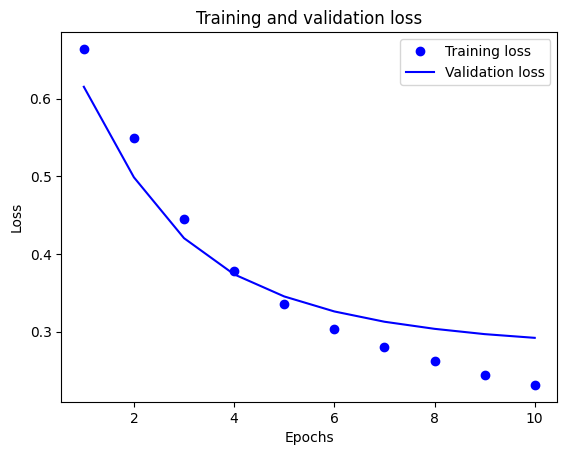

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

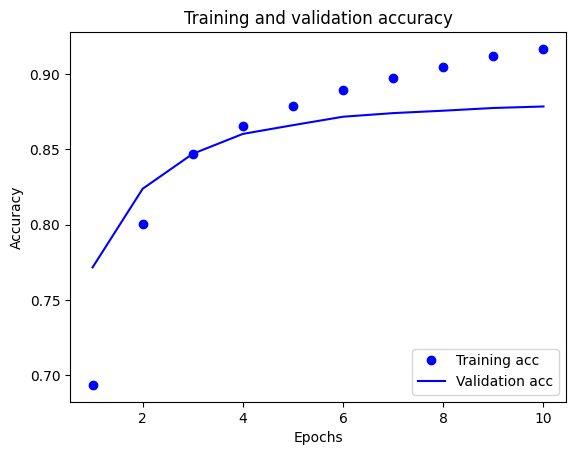

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 2:52 - loss: 0.2847 - accuracy: 0.8438

 19/782 [..............................] - ETA: 2s - loss: 0.3126 - accuracy: 0.8882  

 37/782 [>.............................] - ETA: 2s - loss: 0.3122 - accuracy: 0.8792

 55/782 [=>............................] - ETA: 2s - loss: 0.3119 - accuracy: 0.8773

 73/782 [=>............................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8844

 91/782 [==>...........................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8822

109/782 [===>..........................] - ETA: 1s - loss: 0.2990 - accuracy: 0.8796

127/782 [===>..........................] - ETA: 1s - loss: 0.2992 - accuracy: 0.8782

145/782 [====>.........................] - ETA: 1s - loss: 0.3021 - accuracy: 0.8748

164/782 [=====>........................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8748

183/782 [======>.......................] - ETA: 1s - loss: 0.3028 - accuracy: 0.8747

202/782 [======>.......................] - ETA: 1s - loss: 0.3035 - accuracy: 0.8745

220/782 [=======>......................] - ETA: 1s - loss: 0.3047 - accuracy: 0.8751

238/782 [========>.....................] - ETA: 1s - loss: 0.3064 - accuracy: 0.8753

257/782 [========>.....................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8766

275/782 [=========>....................] - ETA: 1s - loss: 0.3076 - accuracy: 0.8745

293/782 [==========>...................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8738

311/782 [==========>...................] - ETA: 1s - loss: 0.3099 - accuracy: 0.8736

330/782 [===========>..................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8742

348/782 [============>.................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8730

366/782 [=============>................] - ETA: 1s - loss: 0.3107 - accuracy: 0.8735

385/782 [=============>................] - ETA: 1s - loss: 0.3103 - accuracy: 0.8737

404/782 [==============>...............] - ETA: 1s - loss: 0.3110 - accuracy: 0.8734

423/782 [===============>..............] - ETA: 1s - loss: 0.3093 - accuracy: 0.8743

442/782 [===============>..............] - ETA: 0s - loss: 0.3094 - accuracy: 0.8745

460/782 [================>.............] - ETA: 0s - loss: 0.3085 - accuracy: 0.8750

479/782 [=================>............] - ETA: 0s - loss: 0.3082 - accuracy: 0.8748

497/782 [==================>...........] - ETA: 0s - loss: 0.3086 - accuracy: 0.8745

515/782 [==================>...........] - ETA: 0s - loss: 0.3083 - accuracy: 0.8746

533/782 [===================>..........] - ETA: 0s - loss: 0.3082 - accuracy: 0.8745

552/782 [====================>.........] - ETA: 0s - loss: 0.3082 - accuracy: 0.8751

571/782 [====================>.........] - ETA: 0s - loss: 0.3078 - accuracy: 0.8751

590/782 [=====================>........] - ETA: 0s - loss: 0.3073 - accuracy: 0.8753

609/782 [======================>.......] - ETA: 0s - loss: 0.3087 - accuracy: 0.8744

628/782 [=======================>......] - ETA: 0s - loss: 0.3088 - accuracy: 0.8746

647/782 [=======================>......] - ETA: 0s - loss: 0.3092 - accuracy: 0.8745

665/782 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.8742

684/782 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8739

703/782 [=========================>....] - ETA: 0s - loss: 0.3097 - accuracy: 0.8737

722/782 [==========================>...] - ETA: 0s - loss: 0.3095 - accuracy: 0.8734

741/782 [===========================>..] - ETA: 0s - loss: 0.3101 - accuracy: 0.8734

760/782 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8736

779/782 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.8736

782/782 [==============================] - 2s 3ms/step - loss: 0.3104 - accuracy: 0.8736


0.8736000061035156


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 115ms/step


array([[0.6108572 ],
       [0.4318587 ],
       [0.35010943]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
